# A simple demo for PGVGrow based on PGGAN implementation
### Please run this demo after preprocessing mnist dataset with data_tool.py

In [1]:
import numpy as np
import tensorflow as tf
import imageio
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import data_tool

In [2]:
"""
Hyper-parameters
"""
# different minibatch size for different resolution
minibatch_dict = {4: 256, 8: 256, 16: 128, 32: 64}
# number of channels, 1 for gray images, 3 for RGB images
num_channels = 1
# number of feature maps
nf = 128
# resolution of raw images
resolution = 32
resolution_log2 = int(np.log2(resolution))
init_resolution = 4
# dimension of latent space
z_dim = 128
# number of images used in a phase
dur_nimg = 300000
# number of images used in total
total_nimg = 1800000

# number of images for visualizing
num_row = 10
num_line = 10

In [3]:
# a function for visualizing
def montage(images, grid):

    s = np.shape(images)
    assert s[0] == np.prod(grid) and np.shape(s)[0] == 4
    bigimg = np.zeros((s[1]*grid[0], s[1]*grid[1], s[3]), dtype=np.float32)

    for i in range(grid[0]):
        for j in range(grid[1]):
            bigimg[s[1] * i : s[1] * i + s[1], s[1] * j : s[1] * j + s[1]] += images[grid[1] * i + j]

    return np.rint(bigimg*255).clip(0, 255).astype(np.uint8)

In [4]:
# calculate coefficients with given divergence
def coef_div(d_score, div):

    if div == 'KL':
        s = np.ones_like(d_score)
    elif div == 'LogD':
        s = 1 / (1 + np.exp(d_score))
    elif div == 'JS':
        s = 1 / (1 + np.exp(-d_score))
    elif div == 'Jef':
        s = 1 + np.exp(d_score)

    return np.reshape(s, [-1, 1, 1, 1])

In [5]:
def lod(num_img):

    ph_num = num_img // (2*dur_nimg)
    remain_num = num_img - ph_num * (2 * dur_nimg)

    if np.log2(resolution / init_resolution) <= ph_num:
        return 0.
    elif remain_num <= dur_nimg:
        return np.log2(resolution / init_resolution) - ph_num
    else: 
        return np.log2(resolution / init_resolution) - ph_num - (remain_num - dur_nimg) / dur_nimg

In [6]:
def lerp(a, b, t): return a + (b - a) * t

def cset(cur_lambda, new_cond, new_lambda): return lambda: tf.cond(new_cond, new_lambda, cur_lambda)

def upscale2d(x, factor=2):
    s = x.shape
    x = tf.reshape(x, [-1, s[1], 1, s[2], 1, s[3]])
    x = tf.tile(x, [1, 1, factor, 1, factor, 1])
    x = tf.reshape(x, [-1, s[1] * factor, s[2] * factor, s[3]])
    return x

def downscale2d(x, factor=2):
    return tf.nn.avg_pool(x, ksize=[1, factor, factor, 1], strides=[1, factor, factor, 1], padding='VALID')

def pixel_norm(x, axis=3):
    return x / tf.sqrt(tf.reduce_mean(tf.square(x), axis=axis, keepdims=True) + 1e-6)

In [7]:
def generator(latents_in, lod_in, num_channels=num_channels, resolution=resolution, latent_size=z_dim, num_features=nf, reuse=None):

    def G_block(x, res):
        with tf.variable_scope('%dx%d' % (2**res, 2**res), reuse=tf.AUTO_REUSE):
            if res == 2:
                x = pixel_norm(x, axis=1)
                with tf.variable_scope('Dense'):
                    w = tf.get_variable('Weight', dtype=tf.float32, shape=[latent_size, num_features*16], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/latent_size), dtype=tf.float32, name='std')
                    x = tf.reshape(tf.matmul(x, w*std), [-1, 4, 4, num_features])
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = pixel_norm(tf.nn.leaky_relu(x + b, alpha=0.2), axis=1)
                with tf.variable_scope('Conv'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = pixel_norm(tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2))
            else:
                x = upscale2d(x)
                with tf.variable_scope('Conv1'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = pixel_norm(tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2))
                with tf.variable_scope('Conv2'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = pixel_norm(tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2))
            return x

    def FtoI(x, res): # Feature maps to Image
        with tf.variable_scope('FtoI_%dx%d' % (2**res, 2**res), reuse=tf.AUTO_REUSE):
            w = tf.get_variable('Kernel', dtype=tf.float32, shape=[1, 1, num_features, num_channels], initializer=tf.initializers.random_normal())
            std = tf.constant(np.sqrt(1/num_features), dtype=tf.float32, name='std')
            b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_channels], initializer=tf.initializers.zeros())
            x = tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b
            return x

    def grow(x, res, lod):
        y = G_block(x, res)
        img = lambda: upscale2d(FtoI(y, res), 2**lod)
        if res > 2: img = cset(img, (lod_in > lod), lambda: upscale2d(lerp(FtoI(y, res), upscale2d(FtoI(x, res - 1)), lod_in - lod), 2**lod))
        if lod > 0: img = cset(img, (lod_in < lod), lambda: grow(y, res + 1, lod - 1))
        return img()

    with tf.variable_scope('generator', reuse=reuse):
        resolution_log2 = int(np.log2(resolution))
        images_out = grow(latents_in, 2, resolution_log2 - 2)
        return images_out

In [8]:
def discriminator(images_in, lod_in, num_channels=num_channels, resolution=resolution, num_features=nf, reuse=None):

    def D_block(x, res):
        with tf.variable_scope('%dx%d' % (2**res, 2**res), reuse=tf.AUTO_REUSE):
            if res >= 3:
                with tf.variable_scope('Conv1'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2)
                with tf.variable_scope('Conv2'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2)
                x = downscale2d(x)
            else:
                with tf.variable_scope('Conv'):
                    w = tf.get_variable('Kernel', dtype=tf.float32, shape=[3, 3, num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(3*3*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
                    x = tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2)
                with tf.variable_scope('Dense1'):
                    x = tf.layers.flatten(x)
                    w = tf.get_variable('Weight', dtype=tf.float32, shape=[16*num_features, num_features], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(2/(16*num_features)), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=num_features, initializer=tf.initializers.zeros())
                    x = tf.nn.leaky_relu(tf.nn.xw_plus_b(x, w*std, b), alpha=0.2)
                with tf.variable_scope('Dense2'):
                    w = tf.get_variable('Weight', dtype=tf.float32, shape=[num_features, 1], initializer=tf.initializers.random_normal())
                    std = tf.constant(np.sqrt(1/num_features), dtype=tf.float32, name='std')
                    b = tf.get_variable('Bias', dtype=tf.float32, shape=1, initializer=tf.initializers.zeros())
                    x = tf.nn.xw_plus_b(x, w*std, b)
            return x

    def ItoF(x, res): # Image to Feature maps
        with tf.variable_scope('ItoF_%dx%d' % (2**res, 2**res), reuse=tf.AUTO_REUSE):
            w = tf.get_variable('Kernel', dtype=tf.float32, shape=[1, 1, num_channels, num_features], initializer=tf.initializers.random_normal())
            std = tf.constant(np.sqrt(2/num_channels), dtype=tf.float32, name='std')
            b = tf.get_variable('Bias', dtype=tf.float32, shape=[num_features], initializer=tf.initializers.zeros())
            x = tf.nn.leaky_relu(tf.nn.conv2d(x, w*std, strides=[1, 1, 1, 1], padding='SAME') + b, alpha=0.2)
            return x

    def grow(res, lod):
        x = lambda: ItoF(downscale2d(images_in, 2**lod), res)
        if lod > 0: x = cset(x, (lod_in < lod), lambda: grow(res + 1, lod - 1))
        x = D_block(x(), res); y = lambda: x
        if res > 2: y = cset(y, (lod_in > lod), lambda: lerp(x, ItoF(downscale2d(images_in, 2**(lod+1)), res - 1), lod_in - lod))
        return y()

    with tf.variable_scope('discriminator', reuse=reuse):
        resolution_log2 = int(np.log2(resolution))
        scores_out = grow(2, resolution_log2 - 2)
        return scores_out

In [9]:
"""
pre-process real images
"""

def downscale(img):
    s = img.shape
    out = np.reshape(img, [-1, s[1]//2, 2, s[2]//2, 2, s[3]])
    return np.mean(out, axis=(2, 4))

def upscale(img):
    return np.repeat(np.repeat(img, 2, axis=1), 2, axis=2)

def process_real(x, lod_in):
    y = x / 127.5 - 1
    alpha = lod_in - np.floor(lod_in)
    y = (1 - alpha)*y + alpha*upscale(downscale(y))
    for i in range(int(np.floor(lod_in))):
        y = upscale(y)
    return y

In [10]:
"""
bulid graph
"""

x_p    = tf.placeholder(dtype=tf.float32, shape=[None, resolution, resolution, num_channels], name='images')
z_p    = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='latents')
G_z_p  = tf.placeholder(dtype=tf.float32, shape=[None, resolution, resolution, num_channels], name='particles')
lod_in = tf.placeholder(dtype=tf.float32, shape=[], name='level_of_details')

G_z   = generator(z_p, lod_in)

# discriminator loss:
d_real_logits = discriminator(x_p, lod_in)
d_fake_logits = discriminator(G_z_p, lod_in, reuse=True)
loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
loss_d = loss_d_real + loss_d_fake

# generator loss:
loss_g = 0.5 * tf.reduce_mean(tf.reduce_sum((G_z - G_z_p)**2))

# computing gradient:
d_grad = tf.gradients(d_fake_logits, G_z_p)[0]

# optimizers:
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

optimizer_d = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.0, beta2=0.99, epsilon=1e-8, name='opt_d')
update_d    = optimizer_d.minimize(loss_d, var_list=vars_d)

optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.0, beta2=0.99, epsilon=1e-8, name='opt_g')
update_g    = optimizer_g.minimize(loss_g, var_list=vars_g)

reset_optimizer_d = tf.variables_initializer(optimizer_d.variables())
reset_optimizer_g = tf.variables_initializer(optimizer_g.variables())

# KL divergence:

num_img: 150016    |  lod_in: 3.00   |  D real loss: 0.591316   |  D fake loss: 0.696644   |  Projection loss: 260.024963


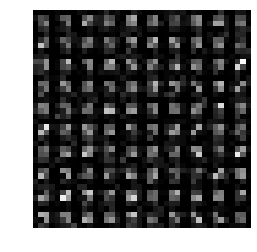

num_img: 300032    |  lod_in: 3.00   |  D real loss: 0.550614   |  D fake loss: 0.837847   |  Projection loss: 101.516434


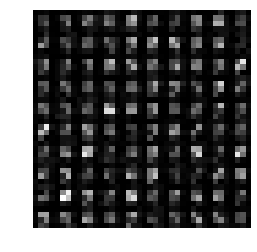

num_img: 450048    |  lod_in: 2.50   |  D real loss: 0.522408   |  D fake loss: 0.794409   |  Projection loss: 717.617310


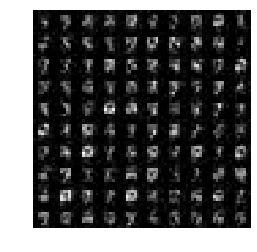

num_img: 600064    |  lod_in: 2.00   |  D real loss: 0.331428   |  D fake loss: 0.762857   |  Projection loss: 8072.871094


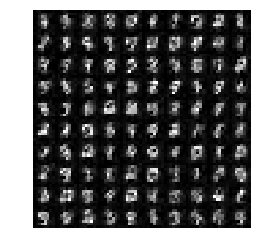

num_img: 750080    |  lod_in: 2.00   |  D real loss: 0.664808   |  D fake loss: 0.513246   |  Projection loss: 416.540436


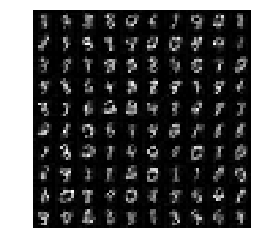

num_img: 900096    |  lod_in: 2.00   |  D real loss: 0.432054   |  D fake loss: 0.820322   |  Projection loss: 1296.840332


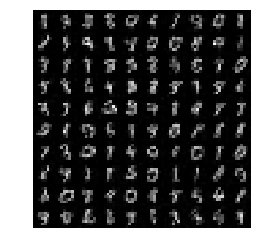

num_img: 1050112    |  lod_in: 1.50   |  D real loss: 0.771759   |  D fake loss: 0.492329   |  Projection loss: 101.999168


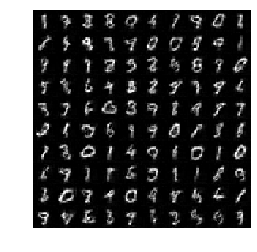

num_img: 1200000    |  lod_in: 1.00   |  D real loss: 0.779223   |  D fake loss: 0.572098   |  Projection loss: 541.852356


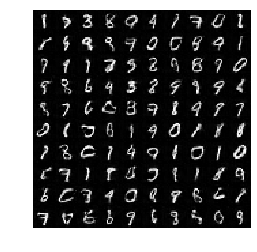

num_img: 1350016    |  lod_in: 1.00   |  D real loss: 0.660166   |  D fake loss: 0.657747   |  Projection loss: 384.506409


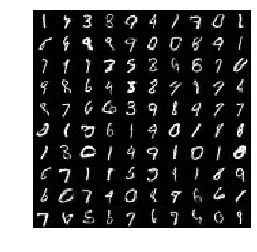

num_img: 1500032    |  lod_in: 1.00   |  D real loss: 0.741778   |  D fake loss: 0.627929   |  Projection loss: 735.130371


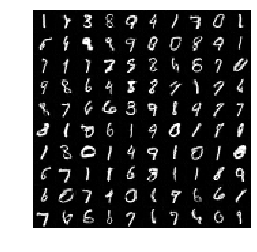

num_img: 1650048    |  lod_in: 0.50   |  D real loss: 0.449239   |  D fake loss: 1.006530   |  Projection loss: 161.164124


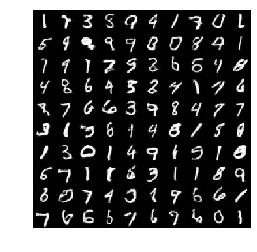

num_img: 1800000    |  lod_in: 0.00   |  D real loss: 0.520611   |  D fake loss: 0.973298   |  Projection loss: 273.571899


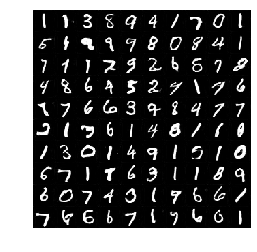

In [11]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_kimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='KL') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if (num_img // 1000) >= tick_kimg + 150:
            tick_kimg = (num_img // 1000)
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# LogD divergence:

num_img: 150016    |  lod_in: 3.00   |  D real loss: 0.567449   |  D fake loss: 0.644464   |  Projection loss: 106.246666


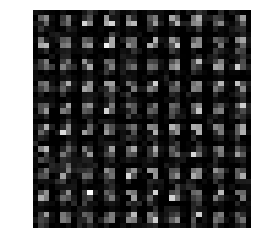

num_img: 300032    |  lod_in: 3.00   |  D real loss: 0.523569   |  D fake loss: 0.841454   |  Projection loss: 22.142120


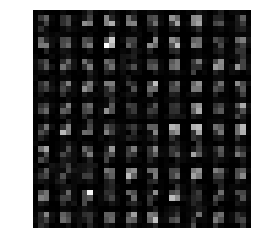

num_img: 450048    |  lod_in: 2.50   |  D real loss: 0.775216   |  D fake loss: 0.522029   |  Projection loss: 808.688843


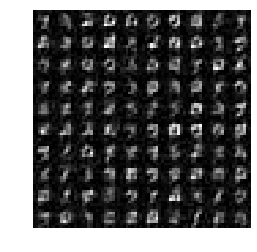

num_img: 600064    |  lod_in: 2.00   |  D real loss: 0.819169   |  D fake loss: 0.345314   |  Projection loss: 1063.771851


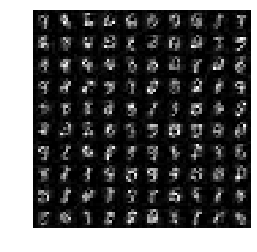

num_img: 750080    |  lod_in: 2.00   |  D real loss: 0.761260   |  D fake loss: 0.392492   |  Projection loss: 591.985107


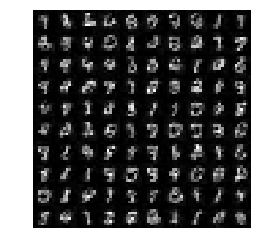

num_img: 900096    |  lod_in: 2.00   |  D real loss: 0.848475   |  D fake loss: 0.381299   |  Projection loss: 295.185852


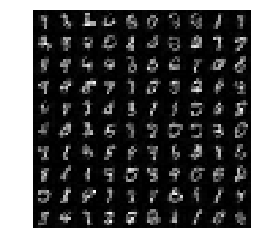

num_img: 1050112    |  lod_in: 1.50   |  D real loss: 0.582467   |  D fake loss: 0.538249   |  Projection loss: 451.086060


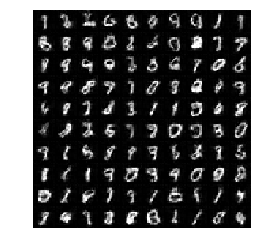

num_img: 1200000    |  lod_in: 1.00   |  D real loss: 0.727262   |  D fake loss: 0.503655   |  Projection loss: 255.944214


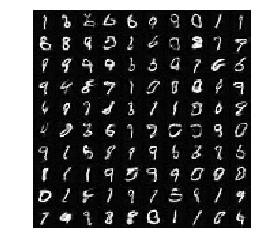

num_img: 1350016    |  lod_in: 1.00   |  D real loss: 0.659677   |  D fake loss: 0.478316   |  Projection loss: 874.813660


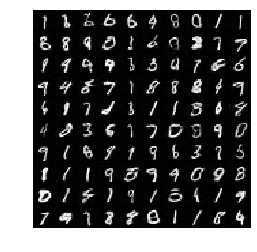

num_img: 1500032    |  lod_in: 1.00   |  D real loss: 0.298711   |  D fake loss: 0.992661   |  Projection loss: 186.165405


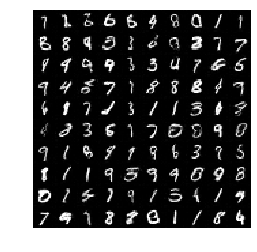

num_img: 1650048    |  lod_in: 0.50   |  D real loss: 0.881626   |  D fake loss: 0.472377   |  Projection loss: 1126.039429


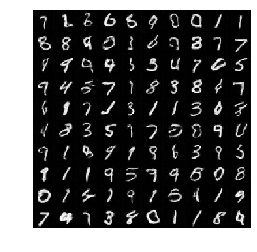

num_img: 1800000    |  lod_in: 0.00   |  D real loss: 1.047747   |  D fake loss: 0.597985   |  Projection loss: 537.614746


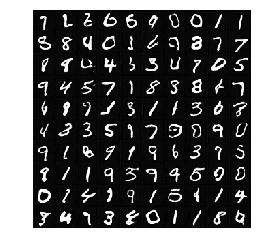

In [12]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_kimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='LogD') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if (num_img // 1000) >= tick_kimg + 150:
            tick_kimg = (num_img // 1000)
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# JS divergence:

num_img: 150016    |  lod_in: 3.00   |  D real loss: 0.691233   |  D fake loss: 0.542787   |  Projection loss: 138.118011


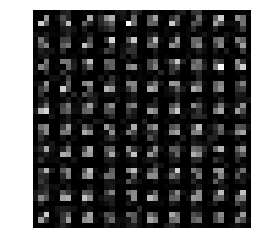

num_img: 300032    |  lod_in: 3.00   |  D real loss: 0.545267   |  D fake loss: 0.814561   |  Projection loss: 123.186256


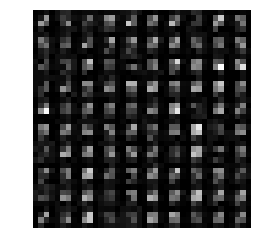

num_img: 450048    |  lod_in: 2.50   |  D real loss: 0.527935   |  D fake loss: 0.742547   |  Projection loss: 54.220413


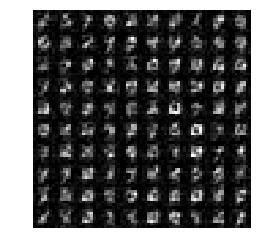

num_img: 600064    |  lod_in: 2.00   |  D real loss: 0.292670   |  D fake loss: 0.840957   |  Projection loss: 1720.251953


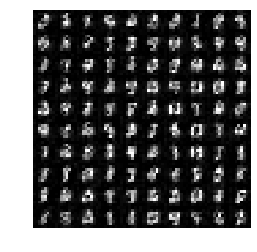

num_img: 750080    |  lod_in: 2.00   |  D real loss: 0.651697   |  D fake loss: 0.363576   |  Projection loss: 336.875977


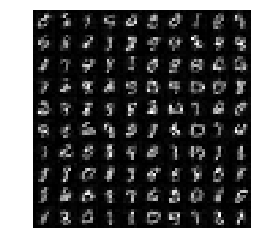

num_img: 900096    |  lod_in: 2.00   |  D real loss: 0.880302   |  D fake loss: 0.236966   |  Projection loss: 313.137939


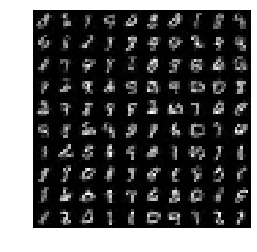

num_img: 1050112    |  lod_in: 1.50   |  D real loss: 0.580149   |  D fake loss: 0.478790   |  Projection loss: 153.876312


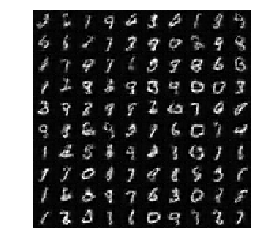

num_img: 1200000    |  lod_in: 1.00   |  D real loss: 0.698974   |  D fake loss: 0.331963   |  Projection loss: 247.011383


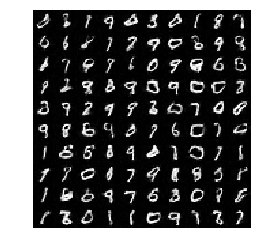

num_img: 1350016    |  lod_in: 1.00   |  D real loss: 0.516469   |  D fake loss: 0.498924   |  Projection loss: 708.838562


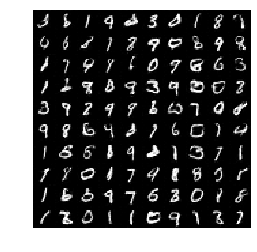

num_img: 1500032    |  lod_in: 1.00   |  D real loss: 0.249414   |  D fake loss: 1.079883   |  Projection loss: 656.473755


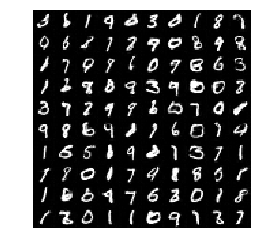

num_img: 1650048    |  lod_in: 0.50   |  D real loss: 0.718196   |  D fake loss: 0.343641   |  Projection loss: 39.262997


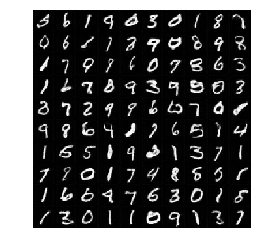

num_img: 1800000    |  lod_in: 0.00   |  D real loss: 0.076173   |  D fake loss: 0.704621   |  Projection loss: 1128.544189


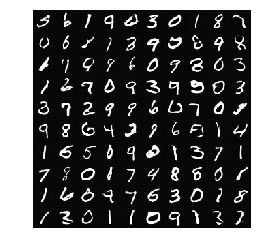

In [13]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_kimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='JS') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if (num_img // 1000) >= tick_kimg + 150:
            tick_kimg = (num_img // 1000)
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# Jef divergence:

num_img: 150016    |  lod_in: 3.00   |  D real loss: 0.537623   |  D fake loss: 0.815906   |  Projection loss: 189.768295


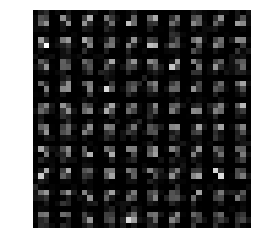

num_img: 300032    |  lod_in: 3.00   |  D real loss: 0.541894   |  D fake loss: 0.866434   |  Projection loss: 127.074196


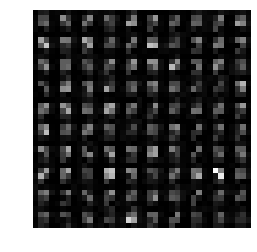

num_img: 450048    |  lod_in: 2.50   |  D real loss: 0.783609   |  D fake loss: 0.502471   |  Projection loss: 127.700562


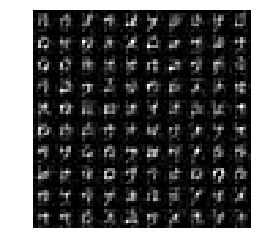

num_img: 600064    |  lod_in: 2.00   |  D real loss: 0.328000   |  D fake loss: 1.147364   |  Projection loss: 1411.010010


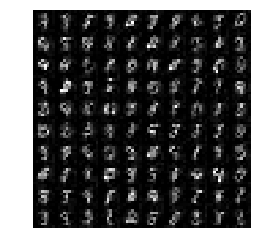

num_img: 750080    |  lod_in: 2.00   |  D real loss: 0.653175   |  D fake loss: 0.546987   |  Projection loss: 539.280151


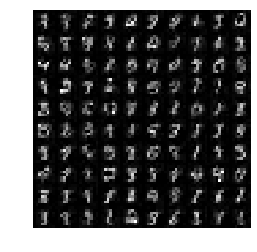

num_img: 900096    |  lod_in: 2.00   |  D real loss: 0.782594   |  D fake loss: 0.447550   |  Projection loss: 485.310303


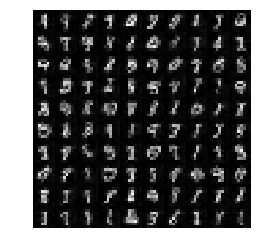

num_img: 1050112    |  lod_in: 1.50   |  D real loss: 0.744075   |  D fake loss: 0.392082   |  Projection loss: 6009.249023


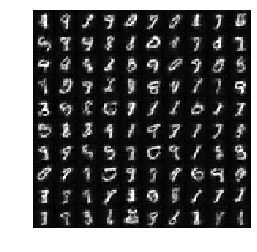

num_img: 1200000    |  lod_in: 1.00   |  D real loss: 0.237811   |  D fake loss: 1.647569   |  Projection loss: 802.883423


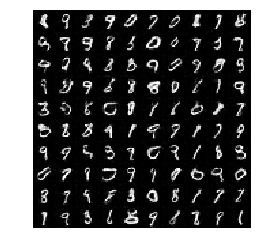

num_img: 1350016    |  lod_in: 1.00   |  D real loss: 0.881809   |  D fake loss: 0.631703   |  Projection loss: 742.526245


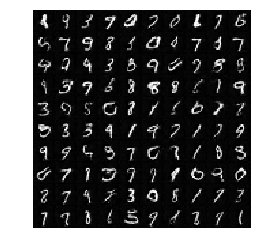

num_img: 1500032    |  lod_in: 1.00   |  D real loss: 0.205220   |  D fake loss: 0.900884   |  Projection loss: 2348.284668


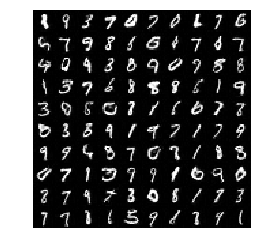

num_img: 1650048    |  lod_in: 0.50   |  D real loss: 0.780826   |  D fake loss: 0.275201   |  Projection loss: 474.478821


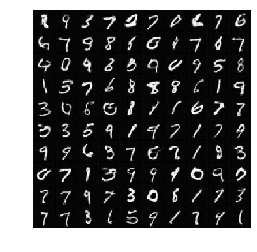

num_img: 1800000    |  lod_in: 0.00   |  D real loss: 0.799796   |  D fake loss: 0.029984   |  Projection loss: 871.280090


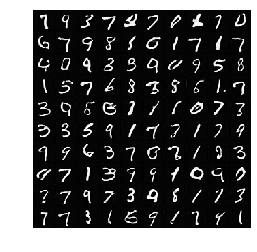

In [14]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_kimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='Jef') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if (num_img // 1000) >= tick_kimg + 150:
            tick_kimg = (num_img // 1000)
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()